In [1]:
import os
import ee
import requests
import zipfile
import rioxarray
import numpy as np
from glob import glob
from io import BytesIO
from datetime import datetime
from sklearn.preprocessing import StandardScaler

ee.Authenticate()
ee.Initialize()

def normalize_tensor(tensor: np.ndarray):
    shape = tensor.shape
    reshaped_tensor = tensor.reshape(-1, shape[-1])

    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(reshaped_tensor)
    
    return normalized_data.reshape(shape) 

def get_image_tensor(
    region, 
    start_date: str, 
    end_date: str, 
    collection_id: str,
    bands: list = None,
    cloud_cover_max: float = 40,
    cloud_cover_field: str = "CLOUD_COVER",
    scale: int = 30,
    crs: str = 'EPSG:4326',
    base_output_dir: str = 'data',
    existing_tensor: np.ndarray = None,
    existing_metadata: list = None,
    flag: bool = False
):
    os.makedirs(base_output_dir, exist_ok=True)

    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt(cloud_cover_field, cloud_cover_max))
        .sort(cloud_cover_field)
    )
    
    count = col.size().getInfo()
    print(f"Найдено {count} снимков")

    images = col.toList(count)
    layers = []
    meta_data = []
    
    for ind in range(count):
        img = ee.Image(images.get(ind))
        date_str = img.date().format("YYYY-MM-dd").getInfo()
        month = datetime.strptime(date_str, "%Y-%m-%d").month
        if month in [12, 1, 2]:
            print(f"  [{ind+1}/{count}] Пропущено по соответствующим месяцам: {date_str}")
            continue

        image_id = img.id().getInfo()
        image_id_safe = image_id.replace('/', '_')
        zip_path = os.path.join(base_output_dir, f"{image_id_safe}.zip")
        extract_dir = os.path.join(base_output_dir, image_id_safe)

        if os.path.exists(extract_dir) and len(glob(f"{extract_dir}/*.tif")) > 0:
            print(f"  [{ind+1}/{count}] Ранее загружено: {image_id} ({date_str})")
        else:
            print(f"  [{ind+1}/{count}] Загрузка: {image_id} ({date_str})")

            if bands is not None:
                img = img.select(bands)
            else:
                bands = img.bandNames().getInfo()

            params = {
                'region': region.getInfo()['coordinates'],
                'scale': scale,
                'crs': crs,
                'fileFormat': 'GeoTIFF'
            }
            url = img.getDownloadURL(params)
            resp = requests.get(url)
            zip_buf = BytesIO(resp.content)

            with open(zip_path, 'wb') as f:
                f.write(zip_buf.getvalue())

            with zipfile.ZipFile(zip_path, 'r') as z:
                z.extractall(extract_dir)

            os.remove(zip_path)

        tif_files = sorted(glob(f"{extract_dir}/*.tif"))
        stack = []
        for tfile in tif_files:
            ds = rioxarray.open_rasterio(tfile).squeeze()
            stack.append(ds.values)

        arr = np.stack(stack, axis=-1)

        for bi, band_name in enumerate(bands):
            layers.append(arr[:, :, bi])
            meta_data.append((date_str, band_name))

    if not layers:
        print("Нет изображений после фильтрации по месяцам.")
        return existing_tensor if flag else None, existing_metadata if flag else None

    new_tensor = normalize_tensor(np.stack(layers, axis=0))

    if flag and existing_tensor is not None:
        if existing_tensor.shape[1:] == new_tensor.shape[1:]:
            tensor = np.concatenate((existing_tensor, new_tensor), axis=0)
            meta_data = (existing_metadata or []) + meta_data
        else:
            print(
                f"Размерности тензоров не совпадают! "
                f"existing_tensor shape: {existing_tensor.shape[1:]}, "
                f"new_tensor shape: {new_tensor.shape[1:]}. "
                f"Новые данные не добавлены."
            )
            tensor = existing_tensor.copy()
            meta_data = existing_metadata.copy() if existing_metadata else []
    else:
        tensor = new_tensor.copy()

    return tensor, meta_data

In [2]:
region = ee.Geometry.Rectangle([
    30.17872139688425, 59.86816653184917,
    30.30690369635918, 59.9963488313241
])

tensor, meta_data = get_image_tensor(
    region=region,
    start_date="2018-01-01",
    end_date="2022-12-31",
    collection_id="LANDSAT/LC08/C02/T1_L2",
    bands=["SR_B1","SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7"],
    cloud_cover_max=40,
    scale=30,
    crs = "EPSG:4326",
    base_output_dir = 'data'
)

print(tensor.shape)

tensor, meta_data = get_image_tensor(
    region=region,
    start_date="2023-01-01",
    end_date="2024-12-31",
    collection_id="LANDSAT/LC09/C02/T1_L2",
    bands=["SR_B1","SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7"],
    cloud_cover_max=40,
    scale=30,
    crs = "EPSG:4326",
    base_output_dir = 'data',
    existing_tensor=tensor,
    existing_metadata=meta_data,
    flag=True
)

print(tensor.shape)

Найдено 64 снимков
  [1/64] Загрузка: LC08_185018_20180512 (2018-05-12)
  [2/64] Загрузка: LC08_185018_20180528 (2018-05-28)
  [3/64] Загрузка: LC08_184018_20220820 (2022-08-20)
  [4/64] Загрузка: LC08_184018_20180521 (2018-05-21)
  [5/64] Загрузка: LC08_185018_20210418 (2021-04-18)
  [6/64] Загрузка: LC08_184018_20200408 (2020-04-08)
  [7/64] Загрузка: LC08_185018_20220624 (2022-06-24)
  [8/64] Загрузка: LC08_184018_20190406 (2019-04-06)
  [9/64] Загрузка: LC08_184018_20210411 (2021-04-11)
  [10/64] Загрузка: LC08_184018_20210310 (2021-03-10)
  [11/64] Загрузка: LC08_184018_20180419 (2018-04-19)
  [12/64] Загрузка: LC08_185018_20220421 (2022-04-21)
  [13/64] Загрузка: LC08_185018_20220912 (2022-09-12)
  [14/64] Загрузка: LC08_184018_20190727 (2019-07-27)
  [15/64] Загрузка: LC08_184018_20200323 (2020-03-23)
  [16/64] Загрузка: LC08_184018_20180809 (2018-08-09)
  [17/64] Загрузка: LC08_184018_20180302 (2018-03-02)
  [18/64] Загрузка: LC08_185018_20181019 (2018-10-19)
  [19/64] Загрузка

In [3]:
layer_idx = 0
layer_array = tensor[layer_idx]
layer_meta = meta_data[layer_idx]

print(f"Слой #{layer_idx}: дата = {layer_meta[0]}, бэнд = {layer_meta[1]}")
print(f"Форма массива: {layer_array.shape}, тип: {layer_array.dtype}")
print("Значения:")
print(layer_array)

Слой #0: дата = 2018-05-12, бэнд = SR_B1
Форма массива: (477, 477), тип: float64
Значения:
[[-0.42349703 -0.42431445 -0.42535245 ... -0.55230799 -0.61909209
  -0.62195991]
 [-0.42510487 -0.42591236 -0.42680723 ... -0.54055097 -0.71745979
  -0.7215854 ]
 [-0.42393553 -0.42475024 -0.42666175 ... -0.59914647 -0.75513253
  -0.75973984]
 ...
 [-0.2038072  -0.20598225 -0.214554   ... -0.46469919 -0.46859141
  -0.53254749]
 [-0.23040969 -0.23242035 -0.19098647 ... -0.61374794 -0.61814076
  -0.600763  ]
 [-0.24283393 -0.24476781 -0.23361169 ... -0.62076423 -0.62518062
  -0.51250677]]


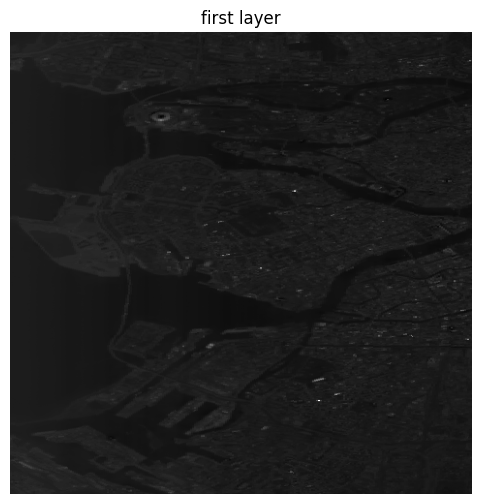

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_from_tensor(tensor, layer_index=0, title="image"):
    layer_image = tensor[layer_index, :, :]

    plt.figure(figsize=(6, 6))
    plt.imshow(layer_image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_layer_from_tensor(tensor, layer_index=0, title="first layer")